In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

import numpy as np

# Download CIFAR 10 data form torchvision

In [2]:

train_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR10('~/datasets/cifar', train=False, download=True)


Files already downloaded and verified
Files already downloaded and verified


In [3]:
np.expand_dims(test_dataset.data[0],0).shape

(1, 32, 32, 3)

# Useful functions

In [4]:
def apply_contrast(images_data, contrast_factor):
    to_tensor = transforms.ToTensor()   
    images_list = [to_tensor(im) for im in images_data]
    images = torch.stack(images_list)
    contrasted_images = F.adjust_contrast(images, contrast_factor)
    contrasted_images = np.array(np.stack([transforms.ToPILImage()(im) for im in contrasted_images]))
    return contrasted_images

def apply_rotation(images_data, angle):
    rotated_images = []
    for img in images_data:
        rotated_image = ndimage.rotate(img, angle, reshape=False)
        rotated_images.append(rotated_image)
    rotated_images = np.array(rotated_images)
    return rotated_images
    

# Generate a list of original and modified images: every original image has a duplicate which is the modified original image.

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import Image 
from scipy import ndimage, misc
import matplotlib.pyplot as plt


contrast_factor = 2 # 0 gray - 1 original image - 2 increases the contrast by a factor of 2.
angle = 70

# Generate a list of original and modified images: every original image has a duplicate which is 
# the modified original image.
def generate_duplicates_modified_original(image_set, mod_factor, mod_type="contrast"):
    original_labels = np.zeros(len(image_set.data))
    modified_labels = np.ones(len(image_set.data))
    
    modified_images = None
    
    if mod_type=="contrast":
        modified_images = apply_contrast(image_set.data, mod_factor) 
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(image_set.data, mod_factor)

    original_and_modified_images = np.concatenate((image_set.data, modified_images), axis=0)
    modification_labels = np.concatenate((original_labels, modified_labels), axis=None)
    image_labels = np.concatenate((image_set.targets, image_set.targets), axis=None)        
    return modified_images, original_and_modified_images, modification_labels, image_labels

train_contr_images, train_images1, train_mod_labels1, train_labels1 = generate_duplicates_modified_original(
    train_dataset, contrast_factor,mod_type="contrast")

test_contr_images, test_images1, test_mod_labels1, test_labels1 = generate_duplicates_modified_original(
    test_dataset, contrast_factor,mod_type="contrast")




print("Combined contrasted and original train images shape")
print(train_images1.shape)


# Visualizing some of the generated contrast adjusted images

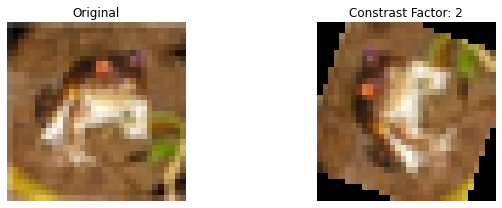

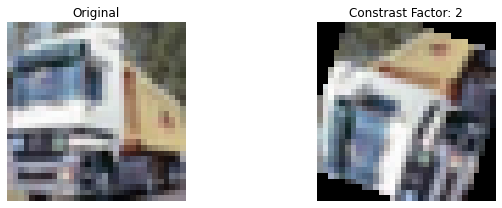

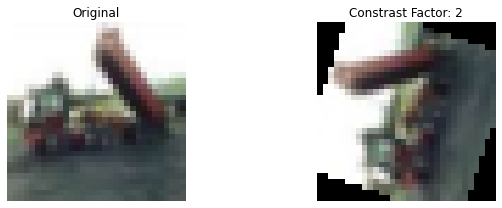

In [6]:

def visualize_original_and_modified_images(original_images, modified_images, mod_type="contrast"):
    i=0
    for modified_image in modified_images:
        fig = plt.figure(figsize=(10, 3))
        ax1,ax2 = fig.subplots(1,2)
        ax1.imshow(original_images[i], cmap='gray')
        ax1.set_axis_off()
        ax1.set_title("Original")
        ax2.imshow(modified_image, cmap='gray')
        ax2.set_axis_off()
        if mod_type=="contrast":
            ax2.set_title("Constrast Factor: "+str(contrast_factor))
        elif mod_type=="rotation":
            ax2.set_title("Rotated at rotation angle: "+str(angle))
        fig.set_tight_layout(True)
        plt.show()
        i +=1

        if i==3:
            break
            
visualize_original_and_modified_images(train_dataset.data, train_contr_images, mod_type="contrast")
    

# Creating sets of images in a way that correlates the way images are modified with label

In [8]:
# used to binarize the target variable
def binarize(y):    
    y = np.copy(y) > 5
    return y.astype(int)

def correlate_label_with_img_modification(image_dataset, mod_factor, mod_percent= 0.1, 
                                          binarize_label=True, mod_type="contrast"):
    y = binarize(image_dataset.targets)
    mod_labels = np.logical_xor(y, np.random.binomial(1, mod_percent, size=len(y)))
    
    images_to_be_modified = image_dataset.data[mod_labels]
    images_to_be_left_alone = image_dataset.data[~mod_labels]
    
    all_img_labels = None
    
    if binarize_label:
        modified_imgs_labels = y[mod_labels]
        unmodified_imgs_labels = y[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)
    else:
        modified_imgs_labels = np.array(image_dataset.targets)[mod_labels]
        unmodified_imgs_labels = np.array(image_dataset.targets)[~mod_labels]
        all_img_labels = np.concatenate((modified_imgs_labels, unmodified_imgs_labels), axis=None)    
    
    all_images = None
    
    if mod_type == "contrast":
        modified_images = apply_contrast(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)                    
        
    elif mod_type=="rotation":
        modified_images = apply_rotation(images_to_be_modified, mod_factor)
        all_images = np.concatenate((modified_images, images_to_be_left_alone), axis=0)
        
    return all_images, all_img_labels, mod_labels.astype(int)
        
        
train_imgs_envs, train_labels2, train_mod_labels2 = correlate_label_with_img_modification(
    train_dataset, contrast_factor, mod_percent= 0.1, binarize_label=False, mod_type="contrast")

test_imgs_envs, test_labels2, test_mod_labels2 = correlate_label_with_img_modification(
    test_dataset, contrast_factor, mod_percent= 0.9, binarize_label=False, mod_type="contrast")





print("Train data shape")
print(train_imgs_envs.shape)

print("Test data shape")
print(test_imgs_envs.shape)


Train data shape
(50000, 32, 32, 3)
Test data shape
(10000, 32, 32, 3)


# Extract image features

In [9]:
from image_feature_extractor import Img2Vec

batch_size = 64

def get_features(images, batch_size):
    Z_list = []
    # img2vec = Img2Vec(model="resnet50")
    img2vec = Img2Vec()
    for first in range(0, len(images), batch_size):
        images_subset = images[first:first+batch_size]
        Z_subset = img2vec.get_vec(images_subset)
        Z_list.append(Z_subset)
    Z = np.vstack(Z_list)
    return Z

In [10]:
Z = get_features(train_images1, batch_size)
Z_test = get_features(test_images1, batch_size)
Z_test_original = get_features(test_dataset.data, batch_size)
Z_test_contrasted = get_features(test_contr_images, batch_size)


print("Shape of extracted features for combined contrasted and original images")
print(Z.shape)

print("Shape of extracted features for original test images")
print(Z_test_original.shape)

print("Shape of extracted features for contrasted test images")
print(Z_test_contrasted.shape)



Z_train_contrast_correlated_with_label = get_features(train_imgs_envs, batch_size)

Z_test_contrast_correlated_with_label = get_features(test_imgs_envs, batch_size)

print("Shape of Z_train_contrast_correlated_with_label")
print(Z_train_contrast_correlated_with_label.shape)

print("Shape of Z_test_contrast_correlated_with_label")
print(Z_test_contrast_correlated_with_label.shape)


Shape of extracted features for combined contrasted and original images
(100000, 512)
Shape of extracted features for original test images
(10000, 512)
Shape of extracted features for contrasted test images
(10000, 512)
Shape of Z_train_contrast_correlated_with_label
(50000, 512)
Shape of test_contrasted_and_uncontrasted_images
(10000, 512)


In [11]:
# from numpy import save
# # save to npy file
# save('Z.npy', Z)
# save('Z_test.npy', Z_test)
# save('Z_test_original.npy', Z_test_original)
# save('Z_test_contrasted.npy', Z_test_contrasted)
# save('Z_train_contrast_correlated_with_label.npy', Z_train_contrast_correlated_with_label)
# save('Z_test_contrast_correlated_with_label.npy', Z_test_contrast_correlated_with_label)


In [12]:
# from numpy import load
# # load array
# Z = load('Z.npy')
# Z_test = load('Z_test.npy')
# Z_test_original = load('Z_test_original.npy')
# Z_test_contrasted = load('Z_test_contrasted.npy')
# Z_train_contrast_correlated_with_label = load('Z_train_contrast_correlated_with_label.npy')
# Z_test_contrast_correlated_with_label = load('Z_test_contrast_correlated_with_label.npy')



# print("Shape of extracted features for combined contrasted and original images")
# print(Z.shape)

# print("Shape of extracted features for original test images")
# print(Z_test_original.shape)

# print("Shape of extracted features for contrasted test images")
# print(Z_test_contrasted.shape)

# print("Shape of extracted features Z_train_contrast_correlated_with_label")
# print(Z_train_contrast_correlated_with_label.shape)

# print("Shape of extracted features Z_test_contrast_correlated_with_label")
# print(Z_test_contrast_correlated_with_label.shape)


# Obtaining contrast prediction coefficients and contrast prediction accuracy

In [13]:
# Using sklearn Logistic Regression
from sklearn.linear_model import LogisticRegression


lr_model = LogisticRegression(random_state=0).fit(Z, train_mod_labels1)

contrast_coefficients = lr_model.coef_.reshape(-1,1)
contrast_coefficients = contrast_coefficients / np.linalg.norm(contrast_coefficients)

print("Contrast coefficients shape")
print(contrast_coefficients.shape)

print('Contrast prediction accuracy on training data-contrasted and uncontrasted images: ', lr_model.score(Z, train_mod_labels1))
print('Contrast prediction accuracy on test data-contrasted and uncontrasted images: ', lr_model.score(Z_test, test_mod_labels1))



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Contrast coefficients shape
(512, 1)
Contrast prediction accuracy on training data-contrasted and uncontrasted images:  0.99966
Contrast prediction accuracy on test data-contrasted and uncontrasted images:  0.99835


# Prediction Accuracies on extracted image features Z ( features obtained from the feature extractor)

### Logistic Regression

In [14]:
# Trained on original extracted image features Z, tested on contrasted extracted image features Z
from sklearn.linear_model import LogisticRegression

import torch
from sklearn import preprocessing


# targets_train = np.array(train_dataset.targets) 
targets_train = train_labels1[:len(train_labels1)//2]
targets_train2 = train_labels2
targets_test = np.array(test_dataset.targets)
targets_test2 = test_labels2

logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z[:len(Z)//2,:], targets_train)

logistic_regression_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(Z_train_contrast_correlated_with_label, targets_train2)


print('LR Accuracy on test data - Z original features: ',logistic_regression_model.score(Z_test_original, targets_test))
# print('LR Accuracy on test data - Z contrasted features: ', logistic_regression_model.score(Z_test_contrasted, targets_test))
print('LR Accuracy on test data - Z - contrast correlated with label: ', logistic_regression_model2.score(Z_test_contrast_correlated_with_label, targets_test2))



/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR Accuracy on test data - Z original features:  0.8739
LR Accuracy on test data - Z - contrast correlated with label:  0.5407


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Find L, get F features, plot histograms and perform predictions

Results for lamda  0.001

Histogram for F Test feature  0


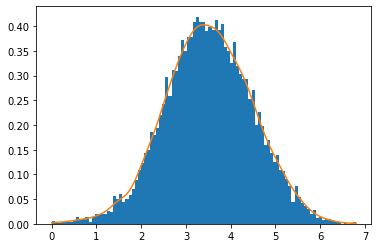

Histogram for F Test feature  1


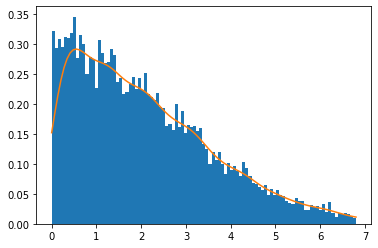

Histogram for F Test feature  2


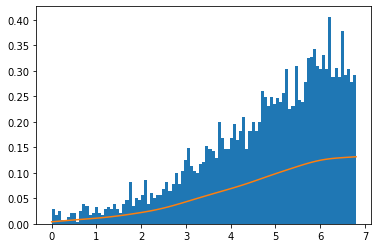

Histogram for F Test feature  3


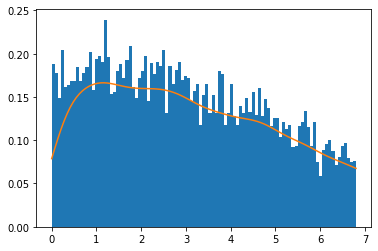

Histogram for F Test feature  4


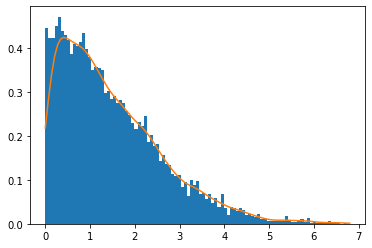

Histogram for F Test feature  5


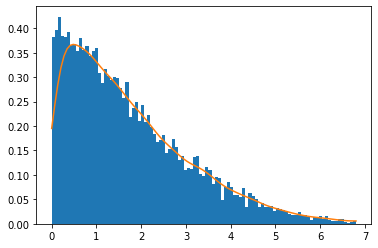

Histogram for F Test feature  6


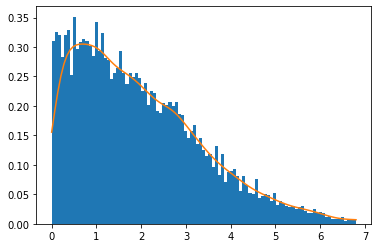

Histogram for F Test feature  7


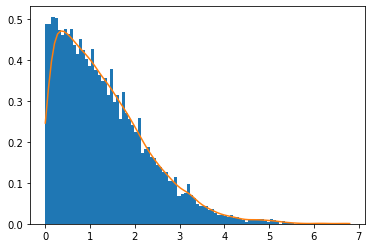

Histogram for F Test feature  8


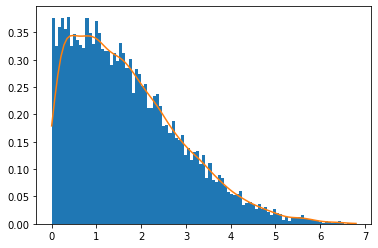

Histogram for F Test feature  9


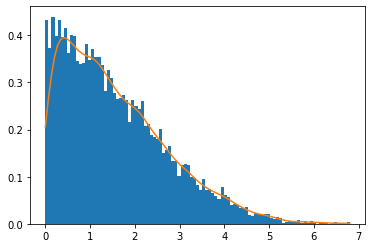

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8736
LR Accuracy on test data - All F features - contrast correlated with label:  0.5509



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8738
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5508


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8731
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5551


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8723
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5447


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8709
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5249


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8676
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5224









Results for lamda  0.01

Histogram for F Test feature  0


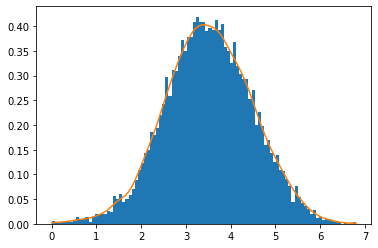

Histogram for F Test feature  1


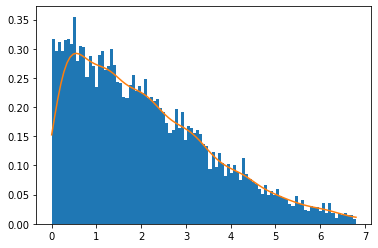

Histogram for F Test feature  2


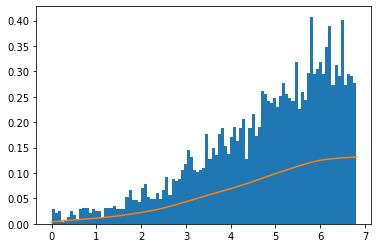

Histogram for F Test feature  3


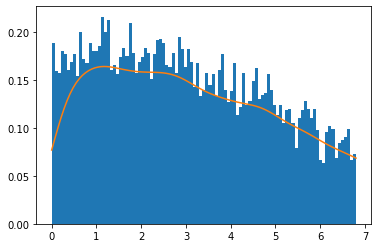

Histogram for F Test feature  4


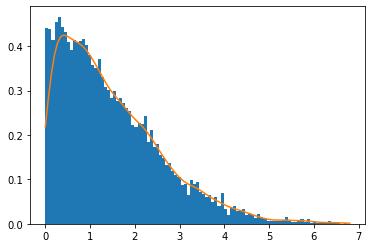

Histogram for F Test feature  5


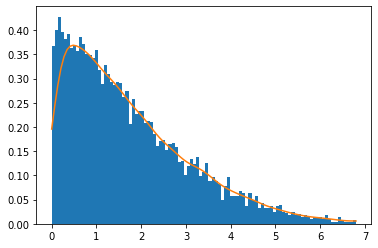

Histogram for F Test feature  6


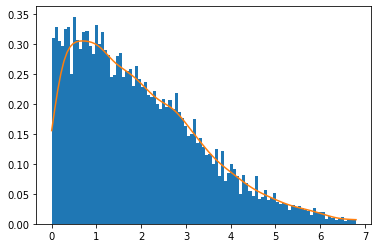

Histogram for F Test feature  7


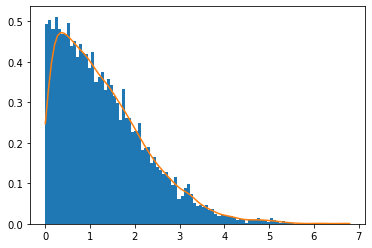

Histogram for F Test feature  8


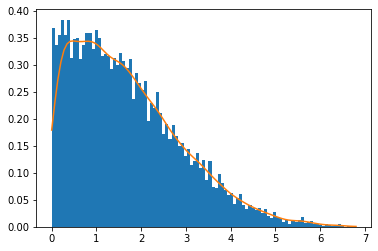

Histogram for F Test feature  9


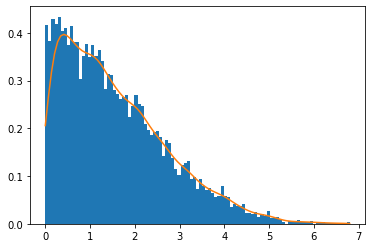

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8732
LR Accuracy on test data - All F features - contrast correlated with label:  0.5442



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8744
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5509


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8716
Logistic Regression Accuracy on test data - contrast correlated with label:  0.555


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8725
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5382


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8701
Logistic Regression Accuracy on test data - contrast correlated with label:  0.526


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8692
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5092









Results for lamda  10

Histogram for F Test feature  0


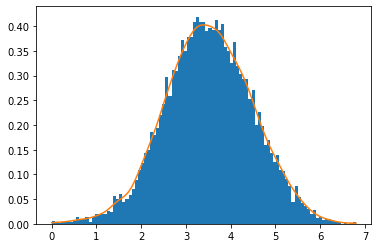

Histogram for F Test feature  1


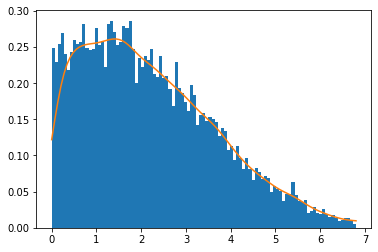

Histogram for F Test feature  2


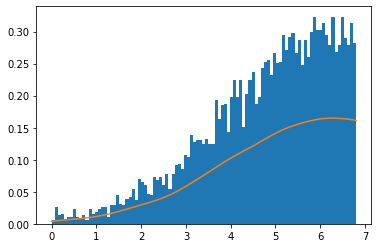

Histogram for F Test feature  3


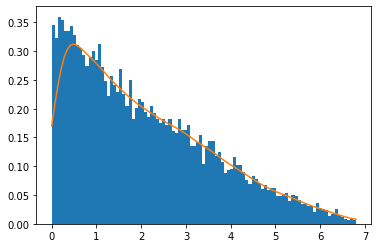

Histogram for F Test feature  4


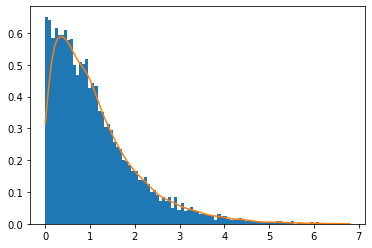

Histogram for F Test feature  5


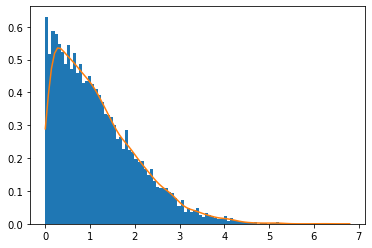

Histogram for F Test feature  6


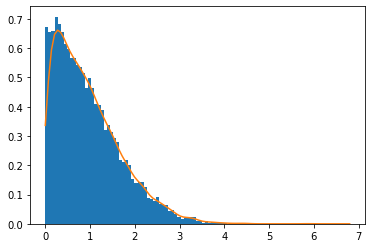

Histogram for F Test feature  7


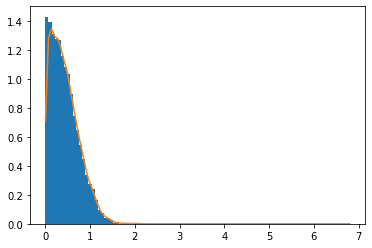

Histogram for F Test feature  8


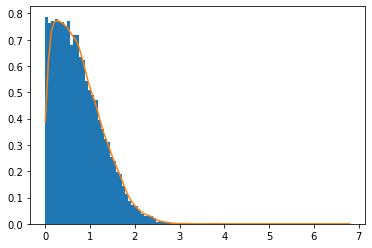

Histogram for F Test feature  9


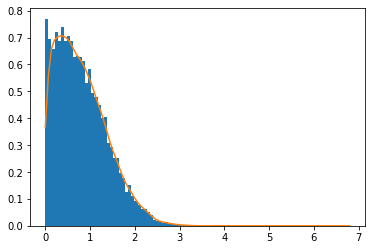

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.865
LR Accuracy on test data - All F features - contrast correlated with label:  0.5302



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8658
Logistic Regression Accuracy on test data - contrast correlated with label:  0.528


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8641
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5334


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8625
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5161


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8635
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5198


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8658
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5155









Results for lamda  100

Histogram for F Test feature  0


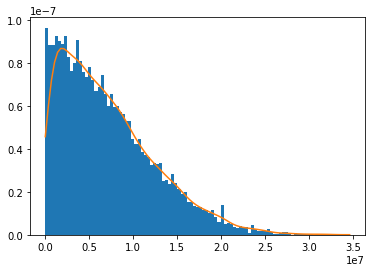

Histogram for F Test feature  1


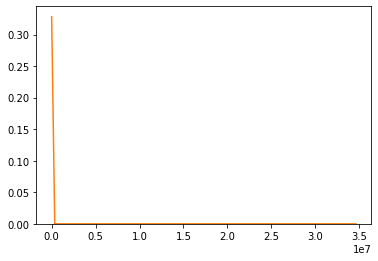

Histogram for F Test feature  2


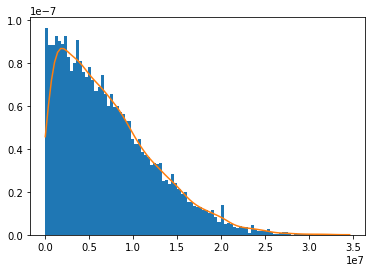

Histogram for F Test feature  3


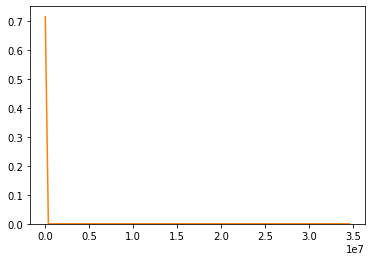

Histogram for F Test feature  4


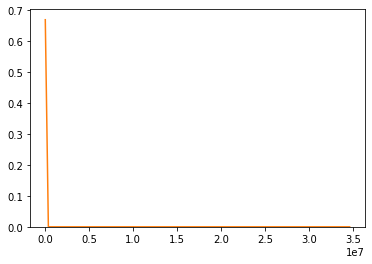

Histogram for F Test feature  5


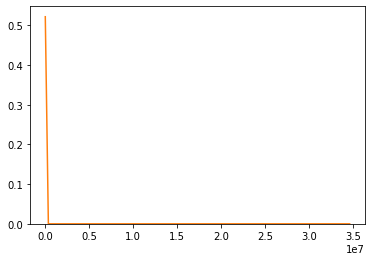

Histogram for F Test feature  6


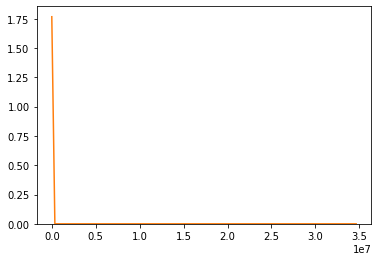

Histogram for F Test feature  7


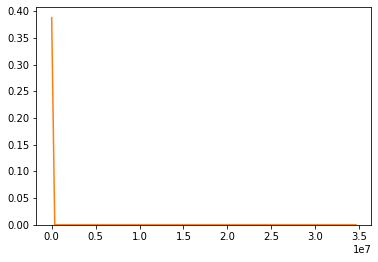

Histogram for F Test feature  8


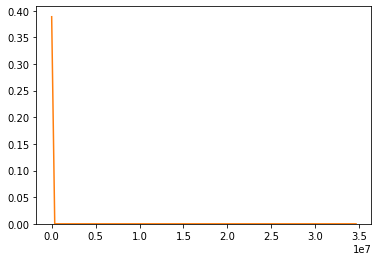

Histogram for F Test feature  9


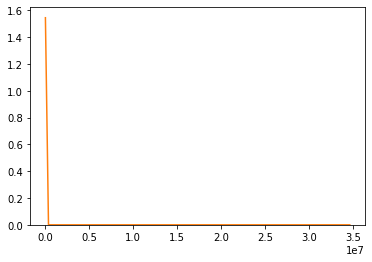

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.1639
LR Accuracy on test data - All F features - contrast correlated with label:  0.11



Accuracy for without F feature  0
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.1639
Logistic Regression Accuracy on test data - contrast correlated with label:  0.11


Accuracy for without F feature  1
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.1639
Logistic Regression Accuracy on test data - contrast correlated with label:  0.11


Accuracy for without F feature  2
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.1639
Logistic Regression Accuracy on test data - contrast correlated with label:  0.11


Accuracy for without F feature  3
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.1639
Logistic Regression Accuracy on test data - contrast correlated with label:  0.11


Acc

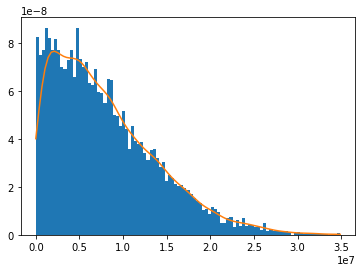

Histogram for F Test feature  1


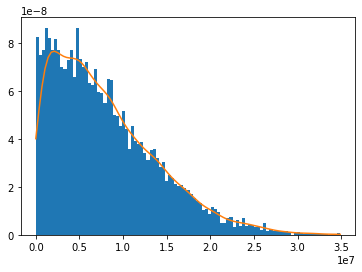

Histogram for F Test feature  2


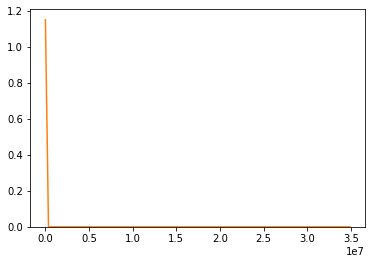

Histogram for F Test feature  3


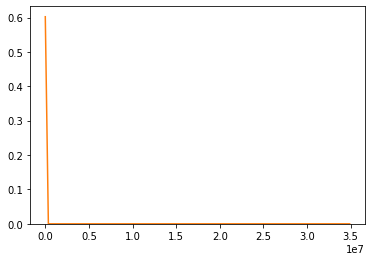

Histogram for F Test feature  4


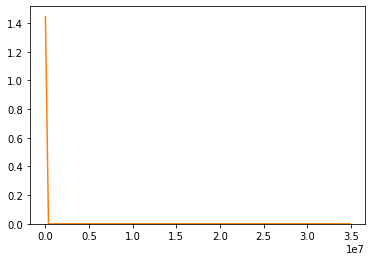

Histogram for F Test feature  5


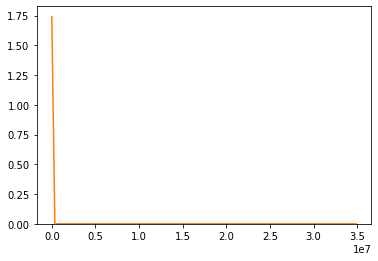

Histogram for F Test feature  6


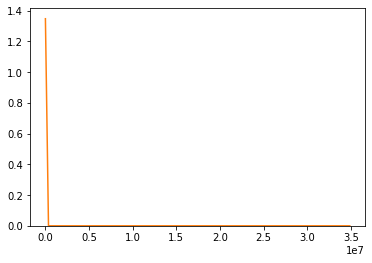

Histogram for F Test feature  7


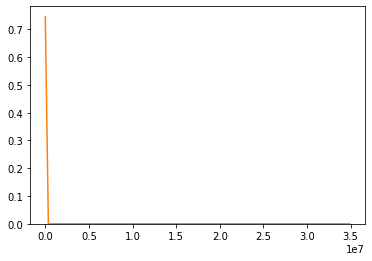

Histogram for F Test feature  8


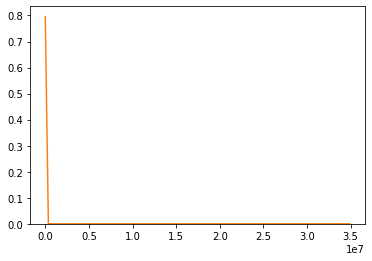

Histogram for F Test feature  9


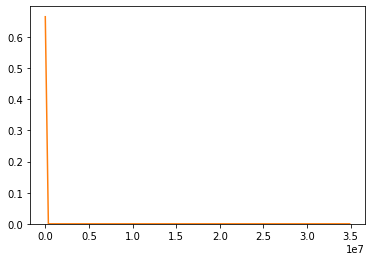

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.112
LR Accuracy on test data - All F features - contrast correlated with label:  0.0997



Accuracy for without F feature  0
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.112
Logistic Regression Accuracy on test data - contrast correlated with label:  0.0997


Accuracy for without F feature  1
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.112
Logistic Regression Accuracy on test data - contrast correlated with label:  0.0997


Accuracy for without F feature  2
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.112
Logistic Regression Accuracy on test data - contrast correlated with label:  0.0997


Accuracy for without F feature  3
Logistic Regression Accuracy on test data - both train and test not contrasted:  0.112
Logistic Regression Accuracy on test data - contrast correlated with label:  0.0997


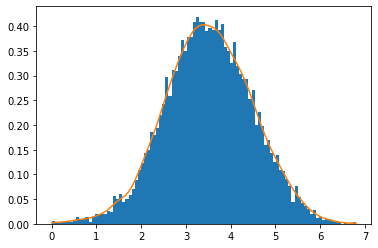

Histogram for F Test feature  1


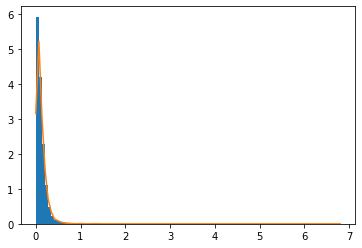

Histogram for F Test feature  2


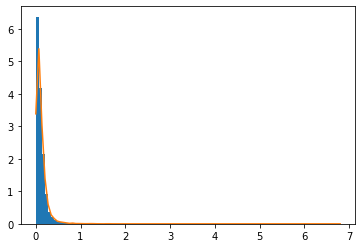

Histogram for F Test feature  3


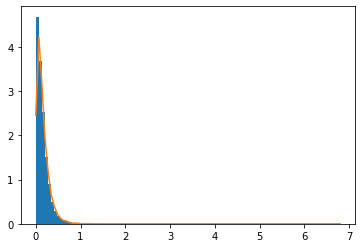

Histogram for F Test feature  4


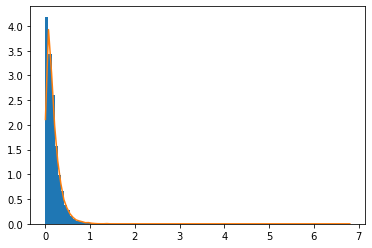

Histogram for F Test feature  5


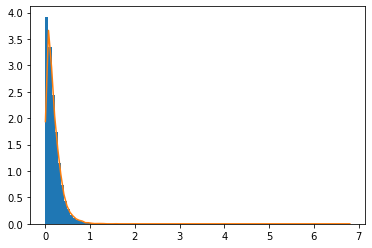

Histogram for F Test feature  6


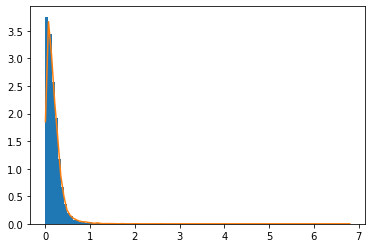

Histogram for F Test feature  7


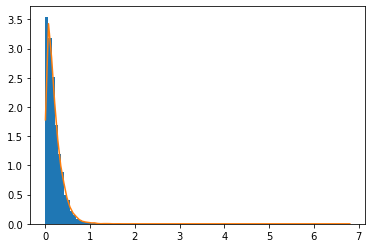

Histogram for F Test feature  8


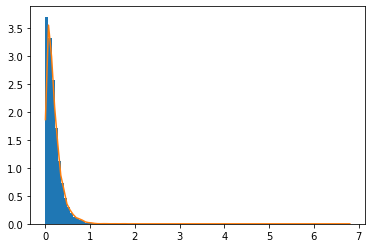

Histogram for F Test feature  9


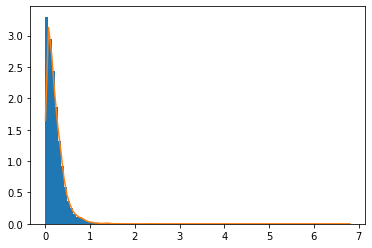

/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8569
LR Accuracy on test data - All F features - contrast correlated with label:  0.5082



Accuracy for without F feature  0


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8564
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5114


Accuracy for without F feature  1


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8574
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5086


Accuracy for without F feature  2


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.857
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5086


Accuracy for without F feature  3


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8576
Logistic Regression Accuracy on test data - contrast correlated with label:  0.5103


Accuracy for without F feature  4


/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy on test data - both train and test not contrasted:  0.8574
Logistic Regression Accuracy on test data - contrast correlated with label:  0.509











/software/anaconda3/envs/invariance_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
import pandas as pd
from scipy import stats
# Computing M
lamdas = [0.001,0.01,10,100,1000,100000]

for lamda in lamdas:
    print("Results for lamda ", lamda)
    print()
    k = int(Z.shape[1]*0.9) # % of original number of features
    n = Z.shape[0]
    delta_Z_matrix = np.absolute((Z[:int(len(train_mod_labels1)/2),:] - Z[int(len(train_mod_labels1)/2):,:]))
    M = - Z.T @ Z/n + lamda * delta_Z_matrix.T @ delta_Z_matrix / (n // 2 ) 


    # Computing the term on which we perform SVD
    alpha_alpha_T = contrast_coefficients @ contrast_coefficients.T
    d = alpha_alpha_T.shape[0]
    I = np.identity(d)
    I_minus_alpa_alpha_T = I-alpha_alpha_T
    term_for_SVD = (I_minus_alpa_alpha_T @ M) @ I_minus_alpa_alpha_T


    # Performing SVD to get eigenvectors and eigenvalues
    from numpy import linalg as LA
    eigenvalues, eigenvectors = LA.eigh(term_for_SVD)

    # Forming L from eigenvectors and alpha
    L_1 = contrast_coefficients
    least_k_eigen_values = eigenvalues[:k]
    least_k_eigen_values[np.absolute(least_k_eigen_values)<0.000001]=0

    non_zero_indeces = None
    if 0 in least_k_eigen_values:
        non_zero_indeces = np.nonzero(least_k_eigen_values)[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[non_zero_indeces]

    else:
        non_zero_indeces = np.nonzero(least_k_eigen_values[:k-1])[0]
        least_k_eigen_values_without_0 = least_k_eigen_values[:k-1]

    L_2 = eigenvectors[:,non_zero_indeces]

    L = np.concatenate((L_1, L_2), axis=1)

   
    # Obtaining F_test values from extracted image features using numpy's linalg.lstsq function.
    F_train_original = torch.from_numpy(np.linalg.lstsq(L, Z[:len(Z)//2,:].transpose(), rcond=None)[0].transpose())
    F_train_contrast_correlated_with_label = torch.from_numpy(np.linalg.lstsq(L, Z_train_contrast_correlated_with_label.transpose(), rcond=None)[0].transpose())
    F_test_original = torch.from_numpy(np.linalg.lstsq(L, Z_test_original.transpose(), rcond=None)[0].transpose())
    F_test_contrasted = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrasted.transpose(), rcond=None)[0].transpose())
    F_test_contrast_correlated_with_label = torch.from_numpy(np.linalg.lstsq(L, Z_test_contrast_correlated_with_label.transpose(), rcond=None)[0].transpose())



    # Plot histograms

    # the difference between F_test_green and F_test_red
    delta_matrix = np.absolute(F_test_original.detach().numpy() - F_test_contrasted.detach().numpy())

#     print("Printing the delta matrix")
    delta_matrix_df = pd.DataFrame(delta_matrix)

    # Plotting the histograms for each feature in the delta matrix # 100 bins
    for i in range(10): #(len(delta_matrix_df.columns)): 
        print("Histogram for F Test feature ", i)    
        feature = delta_matrix_df.iloc[:,i].values
        density = stats.gaussian_kde(feature)
        n, x, _ = plt.hist(feature, bins=np.linspace(0, np.amax(delta_matrix_df.iloc[:,0]), 100), 
                           histtype='bar', density=True)  
        plt.plot(x, density(x))
        plt.show()
    
    
    # Trained on original images, tested on contrasted images: all Features in F_test
    from sklearn.linear_model import LogisticRegression

    import torch
    from sklearn import preprocessing
    from sklearn.neighbors import KNeighborsClassifier #

    X_torch_train = F_train_original
    X_torch_train2 = F_train_contrast_correlated_with_label
    X_torch_test = F_test_contrasted
    X_torch_test2 = F_test_contrast_correlated_with_label
    X_torch_test_within = F_test_original
    
    targets_train = train_labels1[:len(train_labels1)//2]
    targets_train2 = train_labels2
#     targets_test = np.array(test_dataset.targets)
    targets_test2 = test_labels2
    targets_test_within = np.array(test_dataset.targets)

    logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train.detach().numpy(), targets_train)
    logistic_regression_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train2.detach().numpy(), targets_train2)

    print('Logistic Regression Accuracy on test data - both train and test not contrasted: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
#     print('LR Accuracy on test data - contrasted - All F features: ', logistic_regression_model.score(X_torch_test.detach().numpy(), targets_test))
    print('LR Accuracy on test data - All F features - contrast correlated with label: ', logistic_regression_model2.score(X_torch_test2.detach().numpy(), targets_test2))

    print("\n"*2)
    

    # Trained on original images, tested on contrasted images: Contrast Features removed from F_test

    targets_train = train_labels1[:len(train_labels1)//2]
    targets_test = np.array(test_dataset.targets)
    targets_test_within = np.array(test_dataset.targets)

    for i in range(5): #(F_test_original.detach().numpy().shape[1]):
        print("Accuracy for without F feature ",i)

        X_torch_train = F_train_original.detach().numpy().copy()
        X_torch_test = F_test_contrasted.detach().numpy().copy()
        X_torch_test_within = F_test_original.detach().numpy().copy()

        X_torch_train = np.delete(X_torch_train, i, 1)
        X_torch_test = np.delete(X_torch_test, i, 1)
        X_torch_test_within = np.delete(X_torch_test_within, i, 1)
       
        X_torch_train2 = F_train_contrast_correlated_with_label
        X_torch_test2 = F_test_contrast_correlated_with_label

        X_torch_train2 = np.delete(X_torch_train2, i, 1)
        X_torch_test2 = np.delete(X_torch_test2, i, 1)

        logistic_regression_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train, targets_train)
        logistic_regression_model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0).fit(X_torch_train2.detach().numpy(), targets_train2)
        
        print('Logistic Regression Accuracy on test data - both train and test not contrasted: ',logistic_regression_model.score(X_torch_test_within, targets_test_within))
#         print('Logistic Regression Accuracy on test data - contrasted: ', logistic_regression_model.score(X_torch_test, targets_test))
        print('Logistic Regression Accuracy on test data - contrast correlated with label: ', logistic_regression_model2.score(X_torch_test2.detach().numpy(), targets_test2))
        
        print("\n"*1)
    print("\n"*6)

